In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [4]:
# Create customer features
customer_features = transactions_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean'],
    'ProductID': 'nunique',
    'TransactionID': 'count'
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'total_spend', 'avg_transaction', 'std_transaction', 
                           'total_quantity', 'avg_quantity', 'unique_products', 'transaction_count']

# Add customer region (one-hot encoded)
region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
customer_features = pd.merge(customer_features, 
                           pd.concat([customers_df[['CustomerID']], region_dummies], axis=1),
                           on='CustomerID')

# Handle missing values
customer_features = customer_features.fillna(0)

In [7]:
# Scale features
scaler = StandardScaler()
feature_columns = customer_features.columns.drop('CustomerID')
scaled_features = scaler.fit_transform(customer_features[feature_columns])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Create customer index mapping
customer_indices = {cust_id: idx for idx, cust_id in enumerate(customer_features['CustomerID'])}

In [9]:
def get_top_3_lookalikes(customer_id):
    """Get top 3 similar customers for a given customer ID"""
    if customer_id not in customer_indices:
        return []
    
    idx = customer_indices[customer_id]
    similarities = similarity_matrix[idx]
    
    # Get top 3 similar customers (excluding self)
    similar_indices = np.argsort(similarities)[::-1][1:4]
    
    return [(customer_features.iloc[i]['CustomerID'], 
             round(similarities[i], 4)) 
            for i in similar_indices]

# Generate recommendations for first 20 customers
results = []
for cust_id in customers_df['CustomerID'].iloc[:20]:
    similar_customers = get_top_3_lookalikes(cust_id)
    results.append({
        'CustomerID': cust_id,
        'Similar1_ID': similar_customers[0][0],
        'Similar1_Score': similar_customers[0][1],
        'Similar2_ID': similar_customers[1][0],
        'Similar2_Score': similar_customers[1][1],
        'Similar3_ID': similar_customers[2][0],
        'Similar3_Score': similar_customers[2][1]
    })

# Create and save results DataFrame
lookalike_df = pd.DataFrame(results)
lookalike_df.to_csv('Siddharth_Poonam_Lookalike.csv', index=False)
print("Lookalike results saved to CSV file")
print("\nFirst few recommendations:")
print(lookalike_df.head())

Lookalike results saved to CSV file

First few recommendations:
  CustomerID Similar1_ID  Similar1_Score Similar2_ID  Similar2_Score  \
0      C0001       C0107          0.9725       C0011          0.9550   
1      C0002       C0186          0.9430       C0043          0.9065   
2      C0003       C0190          0.8435       C0091          0.8258   
3      C0004       C0102          0.9517       C0113          0.9242   
4      C0005       C0186          0.9531       C0177          0.9436   

  Similar3_ID  Similar3_Score  
0       C0191          0.9496  
1       C0056          0.8914  
2       C0129          0.7951  
3       C0104          0.9187  
4       C0146          0.9421  


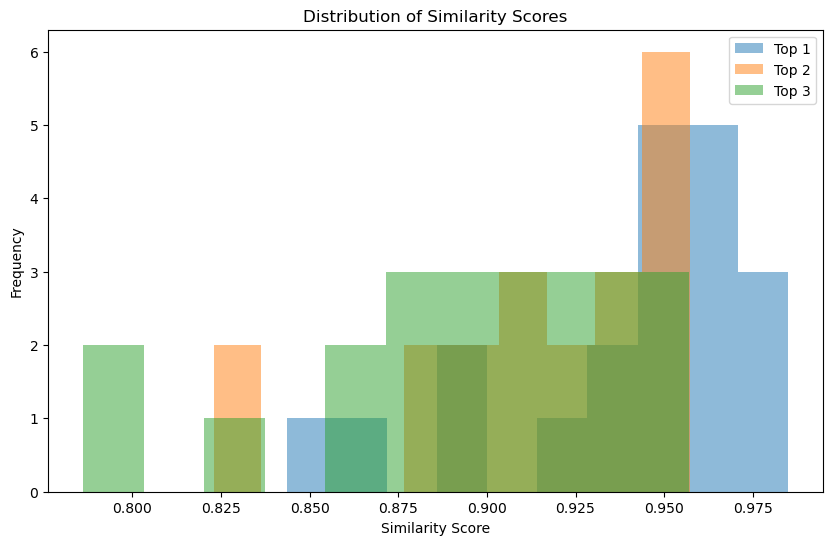

In [11]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize similarity distribution
plt.figure(figsize=(10, 6))
plt.hist([row['Similar1_Score'] for row in results], alpha=0.5, label='Top 1')
plt.hist([row['Similar2_Score'] for row in results], alpha=0.5, label='Top 2')
plt.hist([row['Similar3_Score'] for row in results], alpha=0.5, label='Top 3')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()